In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [10]:
def f(x):
    return 3*x**2 - 4*x + 5

In [11]:
f(3.0)

20.0

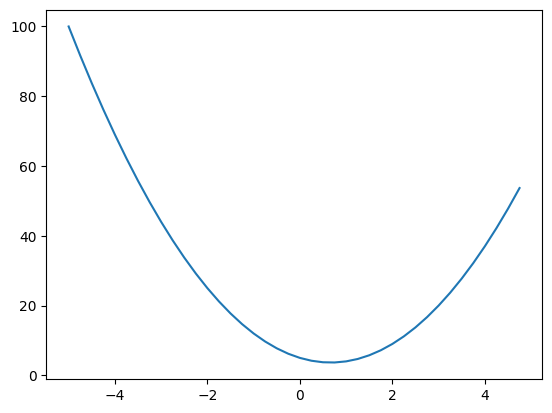

In [12]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [13]:
f(-2 + -3)

100

In [52]:
import random

class Minisor:
    def __init__(self, data, _prevs=(), _op='', _label=''):
        self.data = data
        self.grad = 0.0

        self._backward = lambda: None
        self._prev = set(_prevs)
        self._op = _op
        self._label = _label
    
    def __repr__(self) -> str:
        return f"Minisor(data={self.data}, label='{self._label}')"
    
    def __add__(self, other):
        other = other if isinstance(other, Minisor) else Minisor(other)
        out = Minisor(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + -other
    
    def __rsub__(self, other):
        return self + -other

    def __mul__(self, other):
        other = other if isinstance(other, Minisor) else Minisor(other)
        out = Minisor(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Minisor(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        
        out._backward = _backward
        return out
    
    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return self / other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Minisor(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Minisor(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    build_topo(child)
                topo.append(node)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



class Neuron:
    def __init__(self, n_in):
        self.w = [Minisor(random.uniform(-1, 1)) for _ in range(n_in)]
        self.b = Minisor(random.uniform(-1, 1))

    def __call__(self, x):
        activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    

class Layer:
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    

class MLP:
    def __init__(self, n_in, n_outs):
        size = [n_in] + n_outs
        self.layers = [Layer(size[i], size[i + 1]) for i in range(len(n_outs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [15]:
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': "LR"})

    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n._label, n.data, n.grad), shape='record')

        if n._op:
            dot.node(name = uid + n._op, label = n._op)

            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


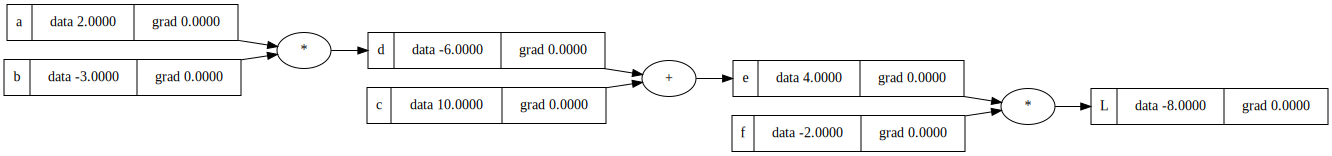

In [16]:
a = Minisor(2.0, _label='a')
b = Minisor(-3.0, _label='b')
c = Minisor(10.0, _label='c')
d = a * b; d._label = 'd'
e = d + c; e._label = 'e'
f = Minisor(-2.0, _label='f')
L = e * f; L._label = 'L'

draw_dot(L)

In [17]:
x1 = Minisor(2.0, _label='x1')
x2 = Minisor(0.0, _label='x2')

w1 = Minisor(-3.0, _label='w1')
w2 = Minisor(1.0, _label='w2')

b = Minisor(6.8813735870195432, _label='b')

x1w1 = x1 * w1; x1w1._label = 'x1w1'
x2w2 = x2 * w2; x2w2._label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1x2w2'
n = x1w1x2w2 + b; n._label = 'n'
o = n.tanh(); o._label = 'o'

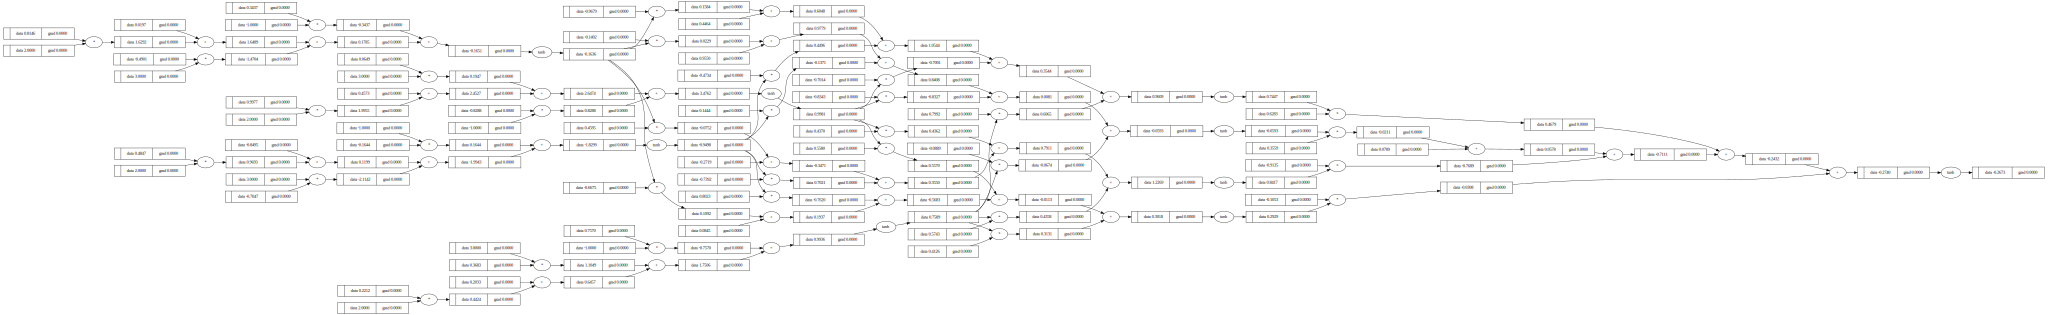

In [33]:
draw_dot(o)


In [19]:
topo = []
visited = set()
def build_topo(node):
    if node not in visited:
        visited.add(node)
        for child in node._prev:
            build_topo(child)
        topo.append(node)
build_topo(o)
print(topo)

[Minisor(data=0.0, label='x2'), Minisor(data=1.0, label='w2'), Minisor(data=0.0, label='x2w2'), Minisor(data=-3.0, label='w1'), Minisor(data=2.0, label='x1'), Minisor(data=-6.0, label='x1w1'), Minisor(data=-6.0, label='x1w1x2w2'), Minisor(data=6.881373587019543, label='b'), Minisor(data=0.8813735870195432, label='n'), Minisor(data=0.7071067811865476, label='o')]


In [40]:
o.backward()

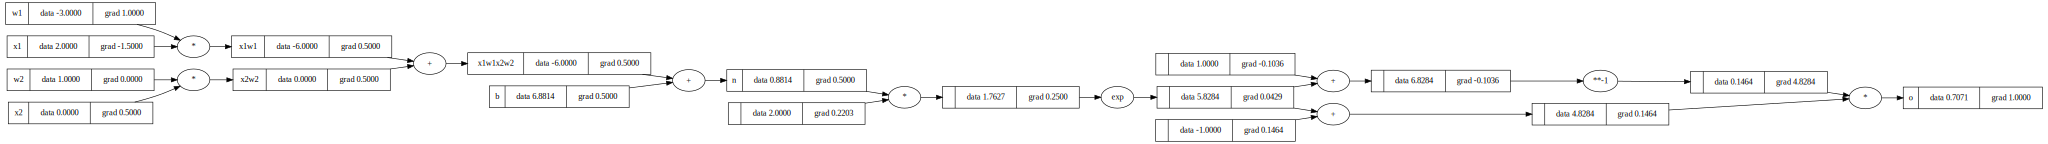

In [20]:
x1 = Minisor(2.0, _label='x1')
x2 = Minisor(0.0, _label='x2')

w1 = Minisor(-3.0, _label='w1')
w2 = Minisor(1.0, _label='w2')

b = Minisor(6.8813735870195432, _label='b')

x1w1 = x1 * w1; x1w1._label = 'x1w1'
x2w2 = x2 * w2; x2w2._label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1x2w2'
n = x1w1x2w2 + b; n._label = 'n'
# ----------------
e = (2 * n).exp()
o = (e - 1) / (e + 1) 
# ----------------
o._label = 'o'

o.backward()
draw_dot(o)

In [53]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Minisor(data=0.44984755660736125, label='')

In [43]:
ypred = [n(x) for x in xs]
loss = sum((y_out - ygt)**2 for y_out, ygt in zip(ys, ypred))
loss

Minisor(data=5.864018609170785, label='')

In [44]:
loss.backward()

In [70]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Minisor(data=0.13354329106609705, label='')

In [81]:
# gradient descent algorithm

for k in range(2000):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((y_out - ygt)**2 for y_out, ygt in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0 # making zerograd
  
    loss.backward()

    for p in n.parameters():
        p.data += -0.1 * p.grad
    
    print(k, loss.data)

0 0.00012248954042740306
1 0.0001224169431250524
2 0.00012234443008110867
3 0.00012227200115038655
4 0.00012219965618803197
5 0.00012212739504952454
6 0.00012205521759067051
7 0.0001219831236676023
8 0.00012191111313678396
9 0.0001218391858550053
10 0.00012176734167937873
11 0.00012169558046734688
12 0.00012162390207667746
13 0.00012155230636545161
14 0.00012148079319208301
15 0.00012140936241529743
16 0.00012133801389414606
17 0.00012126674748800792
18 0.00012119556305655924
19 0.00012112446045981523
20 0.00012105343955809571
21 0.00012098250021204458
22 0.00012091164228260305
23 0.00012084086563105538
24 0.0001207701701189744
25 0.00012069955560825052
26 0.00012062902196109414
27 0.00012055856904002221
28 0.00012048819670785454
29 0.00012041790482772554
30 0.00012034769326307922
31 0.00012027756187766653
32 0.0001202075105355404
33 0.00012013753910106322
34 0.00012006764743889395
35 0.00011999783541400895
36 0.00011992810289167465
37 0.00011985844973746765
38 0.00011978887581726584
3

In [82]:
ypred

[Minisor(data=0.9978416551801357, label=''),
 Minisor(data=-0.9968397864794223, label=''),
 Minisor(data=-0.9947326487353714, label=''),
 Minisor(data=0.9963718399338984, label='')]